In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weather-dataset-rattle-package:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6012%2F1733506%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T191857Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ea07484c3e1cbe0a8e9e28ae48a6a2494f537733877b6c2bd5c64701436120cd2b129650907d129fd6deb3fc8c16429a31ca4dbddaedb91bafb0d2ee5923da24aec2420a1e3ef3b238c245d3f4f92551a7af2965c1f3789c0e5156631647e80a24c8e1a68983b224e3cfc6cd2e14c0405dd9ff1d938be499a5fdac1db754ac692a065b3f4ab2e1ed41d02827b8dbdeb6051b4c2ef601ca0c9daac8b65290ae127d1f2abd1104eb3ebb82433a4bf769118f2e81bb2d73937a80e344aea38cae452b03a8b27dc9a8e04cd0e680475252912f966dec79d73d467b0ccd6a6a89bc2e958526b97de5feb30657c82b91a73823497b307760c541e1f54f14378c7b925'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4020790 bytes downloaded
Downloaded and uncompressed: weather-dataset-rattle-package
Data source import complete.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<Axes: xlabel='RainTomorrow', ylabel='count'>

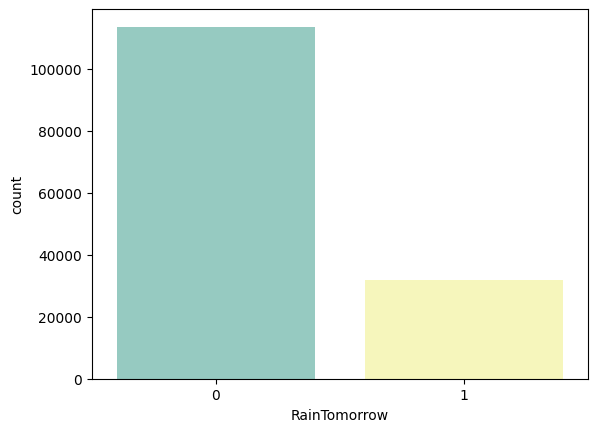

In [65]:
sns.countplot(x = df["RainTomorrow"], palette="Set3")

In [8]:
categorical_features = [column_name for column_name in df.columns if df[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ",categorical_features)

Number of Categorical Features: 7
Categorical Features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [9]:
numerical_features = [column_name for column_name in df.columns if df[column_name].dtype != 'O']


print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ",numerical_features)

Number of Numerical Features: 16
Numerical Features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [10]:
for each_feature in categorical_features:
    print("Cardinality(no. of unique values) of {} are: {}".format(each_feature,len(df[each_feature].unique())))

Cardinality(no. of unique values) of Date are: 3436
Cardinality(no. of unique values) of Location are: 49
Cardinality(no. of unique values) of WindGustDir are: 17
Cardinality(no. of unique values) of WindDir9am are: 17
Cardinality(no. of unique values) of WindDir3pm are: 17
Cardinality(no. of unique values) of RainToday are: 3
Cardinality(no. of unique values) of RainTomorrow are: 3


**Feature enginerring of Date column to decrease high cardinality.**

In [11]:
df["Date"] = pd.to_datetime(df['Date'])
df['Date'].dtype

dtype('<M8[ns]')

In [12]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


In [13]:
df.drop('Date', axis=1, inplace=True)

In [14]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


In [15]:
categorical_features = list(filter(lambda x: df[x].dtype  == 'object', df))
numerical_features = list(filter(lambda x: df[x].dtype != 'object', df))

In [16]:
categorical_null = list(filter(lambda x: df[x].isnull().sum(), df[categorical_features]))
categorical_null

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [17]:
numerical_null = list(filter(lambda x: df[x].isnull().sum(), df[numerical_features]))
numerical_null

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

**Categorical features fill with mode**

In [18]:
for el in categorical_null:
    mode_val = df[el].mode()[0]
    df[el].fillna(mode_val, inplace=True)
df[categorical_null].isnull().sum()


WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

**Numerical features fill with median**

<Axes: >

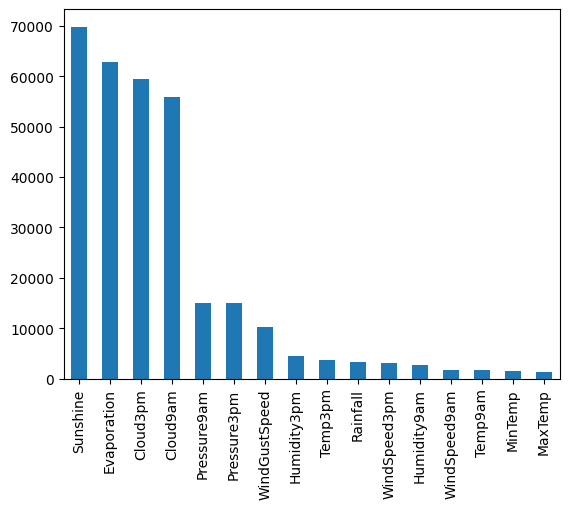

In [19]:
df[numerical_null].isnull().sum().sort_values(ascending=False).plot(kind='bar')

In [20]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,year,month,day
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,2012.769751,6.399615,15.712258
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,2.537684,3.427262,8.794789
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,2013.000000,6.000000,16.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000,2017.000000,12.000000,31.000000


**Handle Outliers**

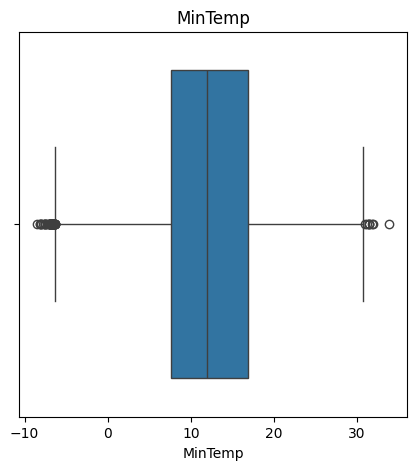

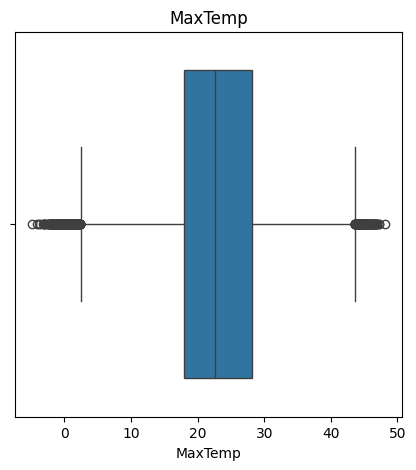

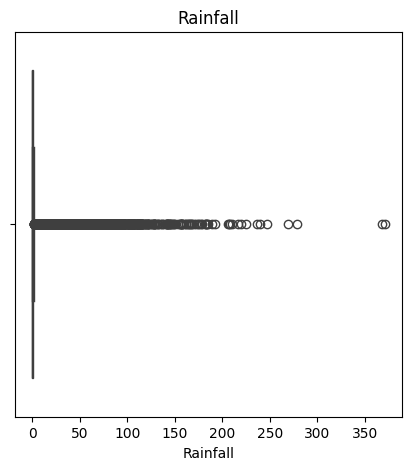

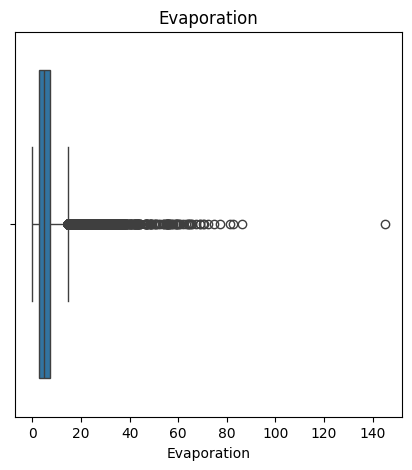

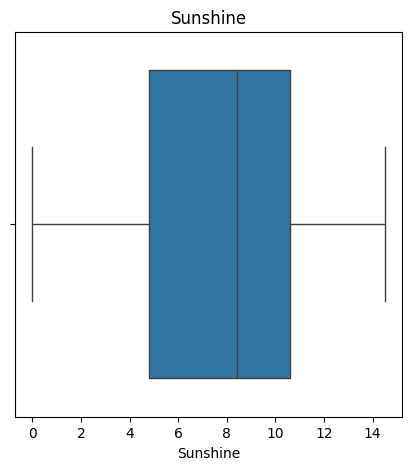

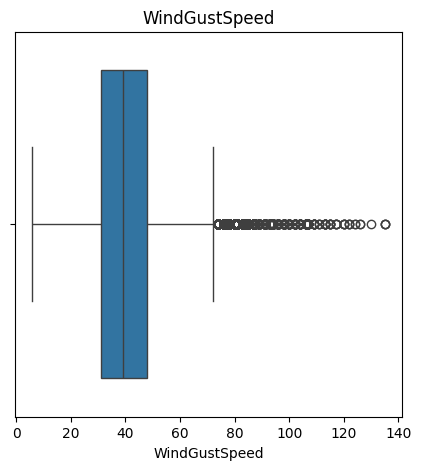

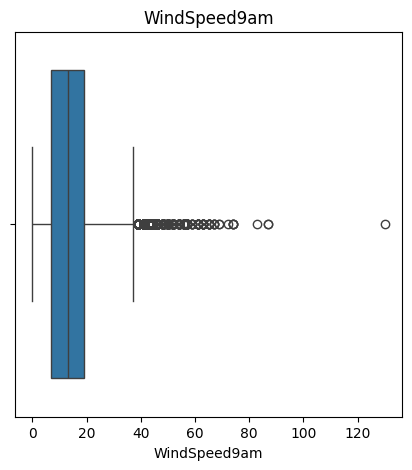

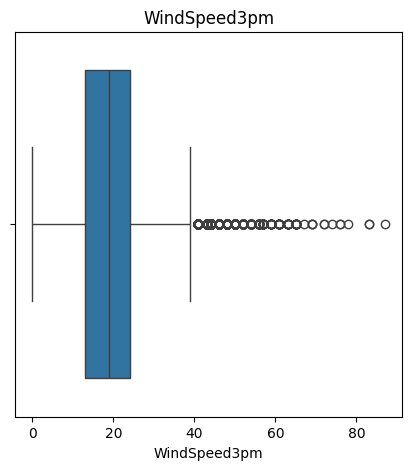

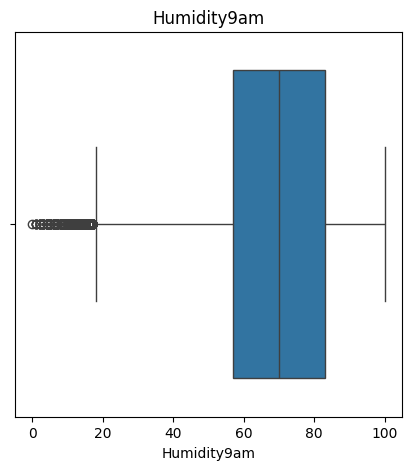

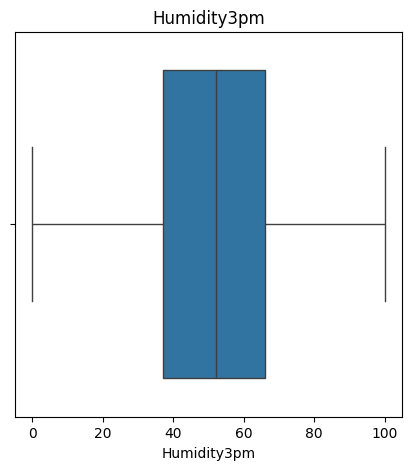

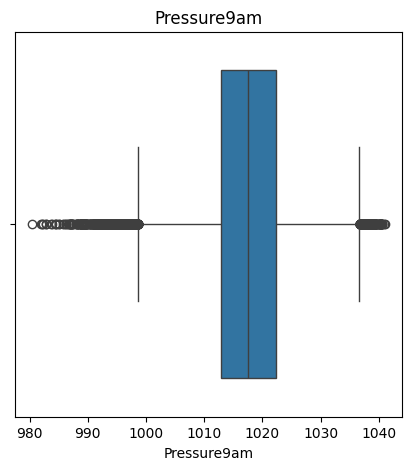

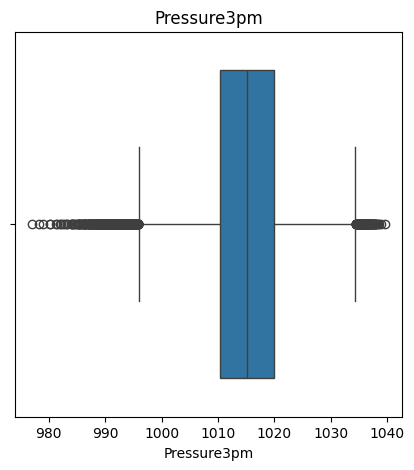

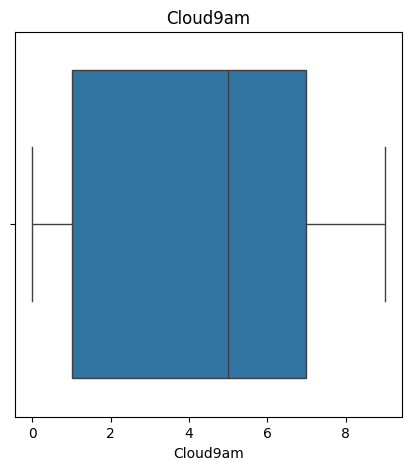

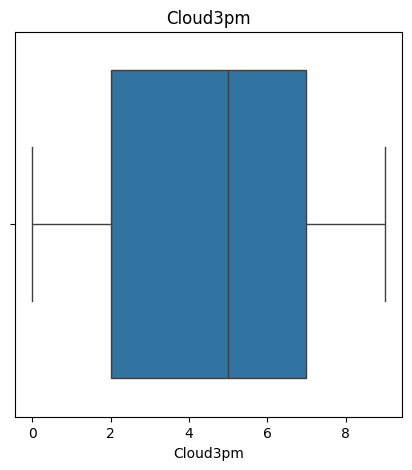

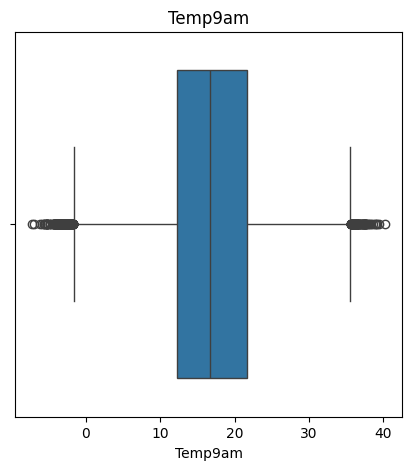

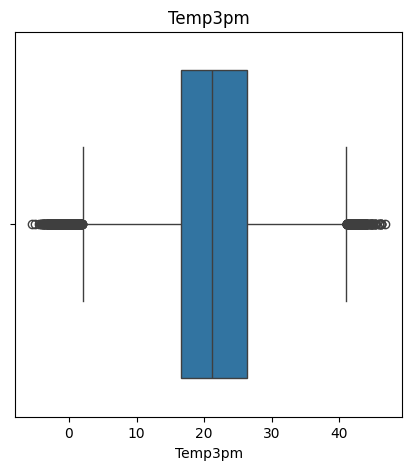

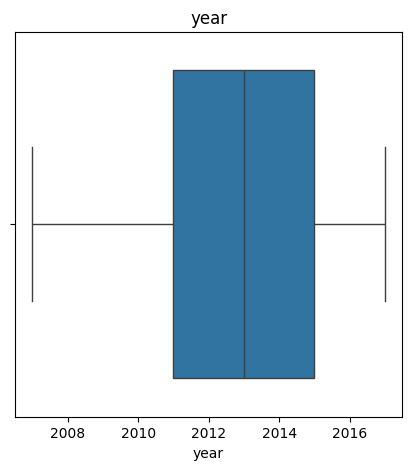

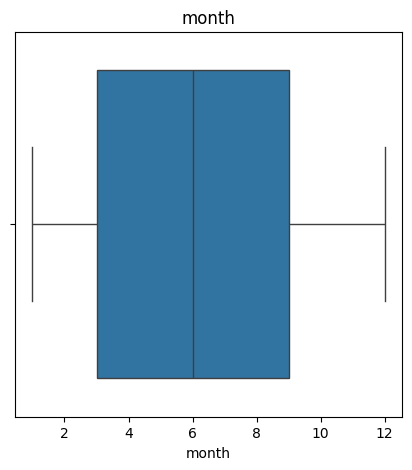

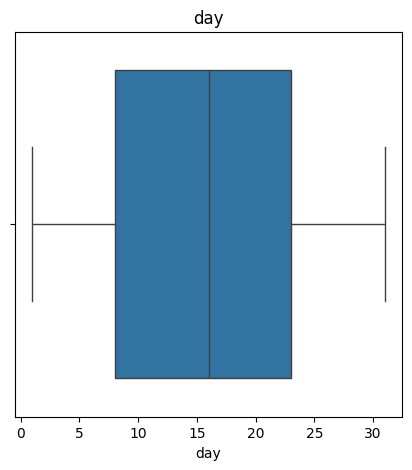

In [21]:
for feature in numerical_features:
    plt.figure(figsize=(5,5))
    sns.boxplot(df[feature], orient='h')
    plt.title(feature)

In [26]:
means = []
stds = []
factor = 1.5

d = {}

for el in numerical_null:
    mean_val = df[el].mean()
    std_val = df[el].std()
    upper_limit = mean_val + std_val * factor
    lower_limit = mean_val - std_val * factor
    d[el] = (upper_limit, lower_limit)
    #df[el] = df[el].clip(lower=lower_limit, upper=upper_limit)
    df[el] = df[el].apply(lambda x: upper_limit if x > upper_limit else (lower_limit if x < lower_limit else x))



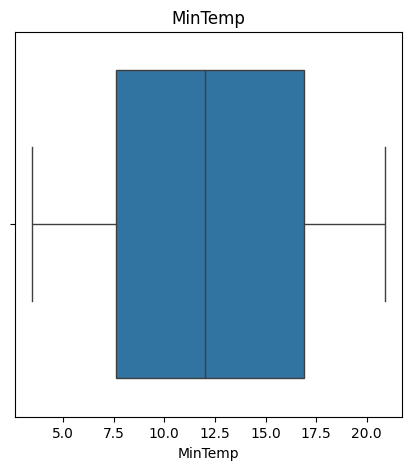

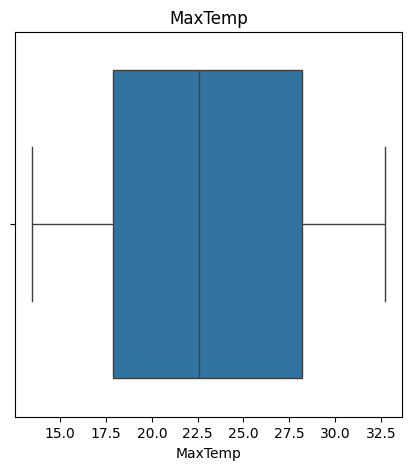

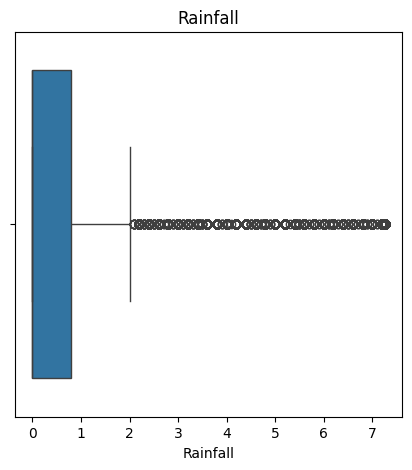

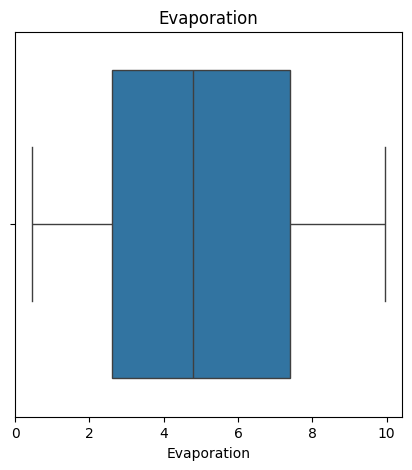

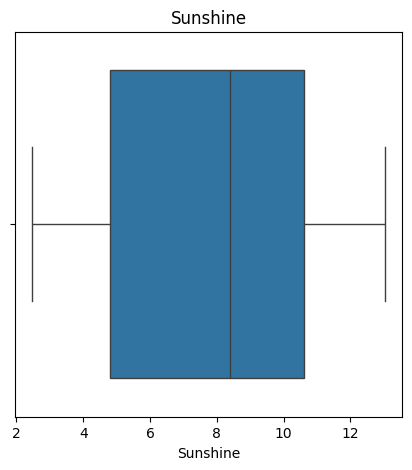

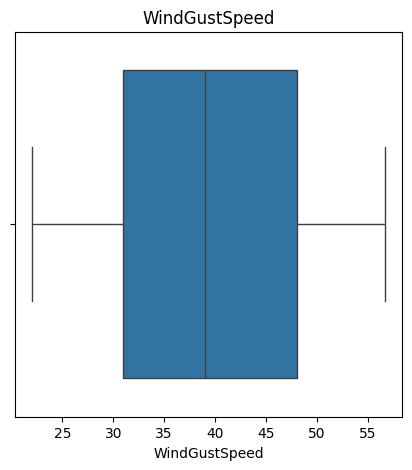

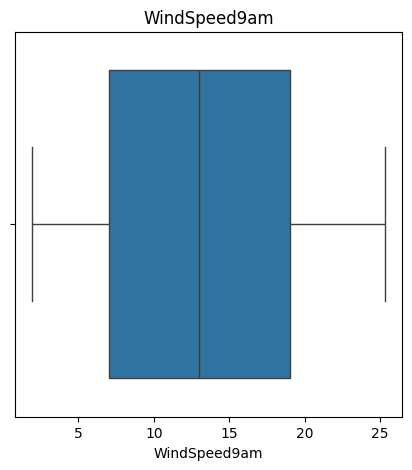

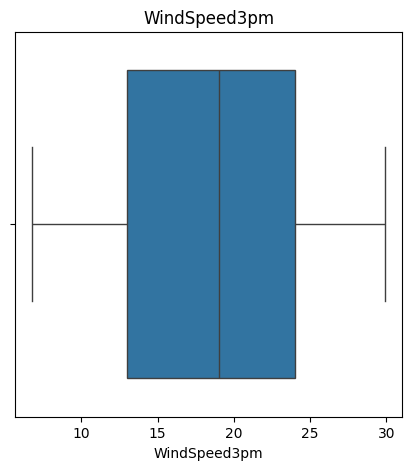

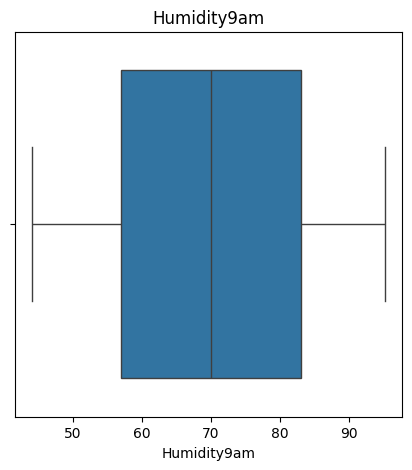

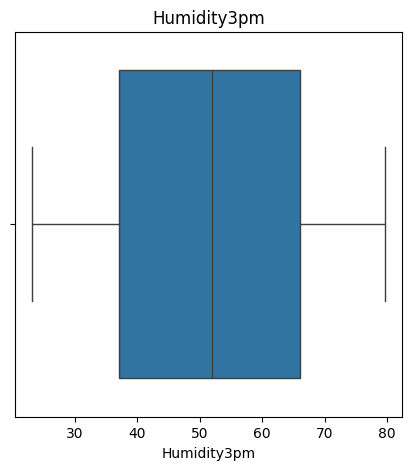

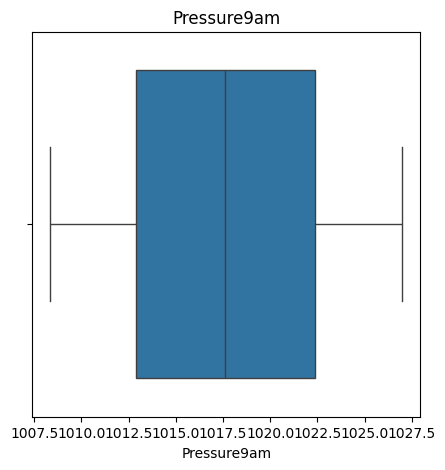

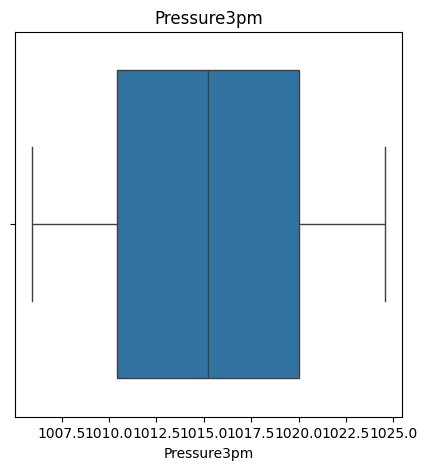

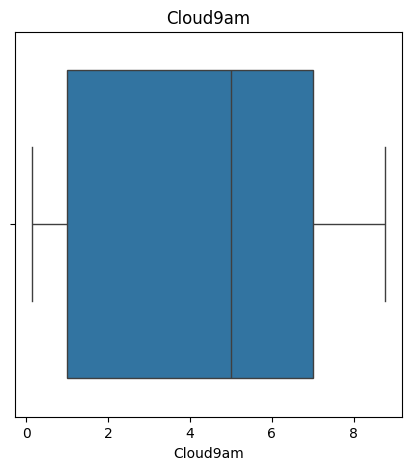

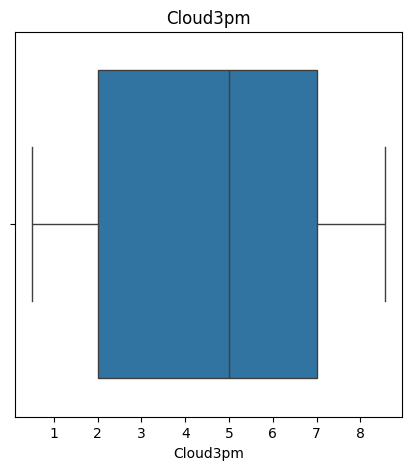

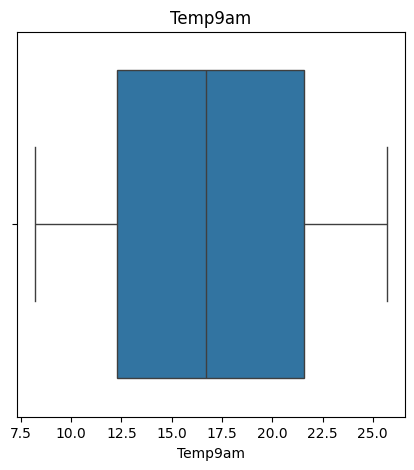

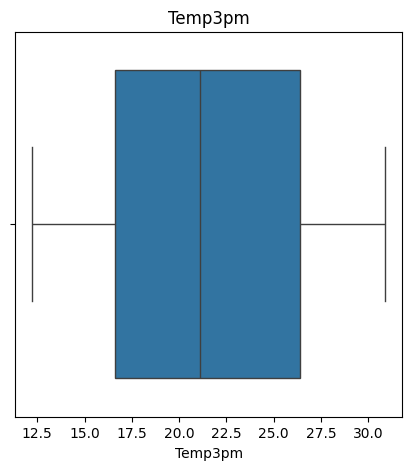

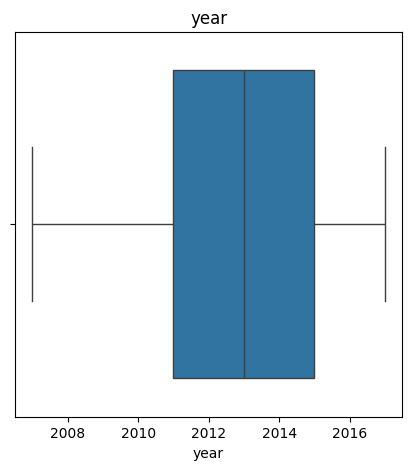

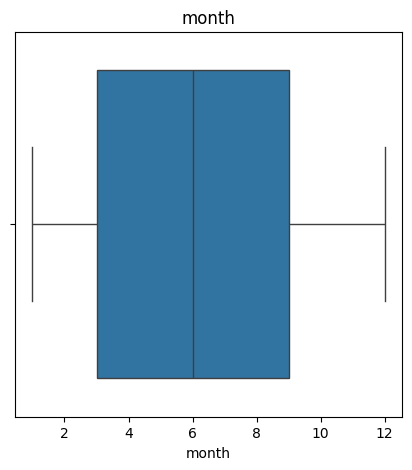

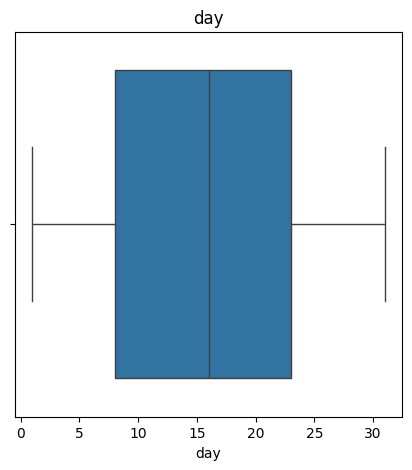

In [25]:
for feature in numerical_features:
    plt.figure(figsize=(5,5))
    sns.boxplot(df[feature], orient='h')
    plt.title(feature)

**Imputing null values in numerical features using mean:**

In [30]:
for column in numerical_null:
    mean_val = df[column].mean()
    df[column] = df[column].fillna(mean_val)

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.900000,0.6,5.007513,7.848206,W,44.0,W,WNW,...,1007.100000,8.000000,4.540513,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.100000,0.0,5.007513,7.848206,WNW,44.0,NNW,WSW,...,1007.800000,4.463418,4.540513,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.700000,0.0,5.007513,7.848206,WSW,46.0,W,WSW,...,1008.700000,4.463418,2.000000,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.000000,0.0,5.007513,7.848206,NE,24.0,SE,E,...,1012.800000,4.463418,4.540513,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.265603,1.0,5.007513,7.848206,W,41.0,ENE,NW,...,1006.434374,7.000000,8.000000,17.8,29.7,No,No,2008,12,5


In [31]:
df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
day              0
dtype: int64

**Check correlation between features (strength of relationship between features)**

1 and -1 strong correlation, 0 is bad

<Axes: >

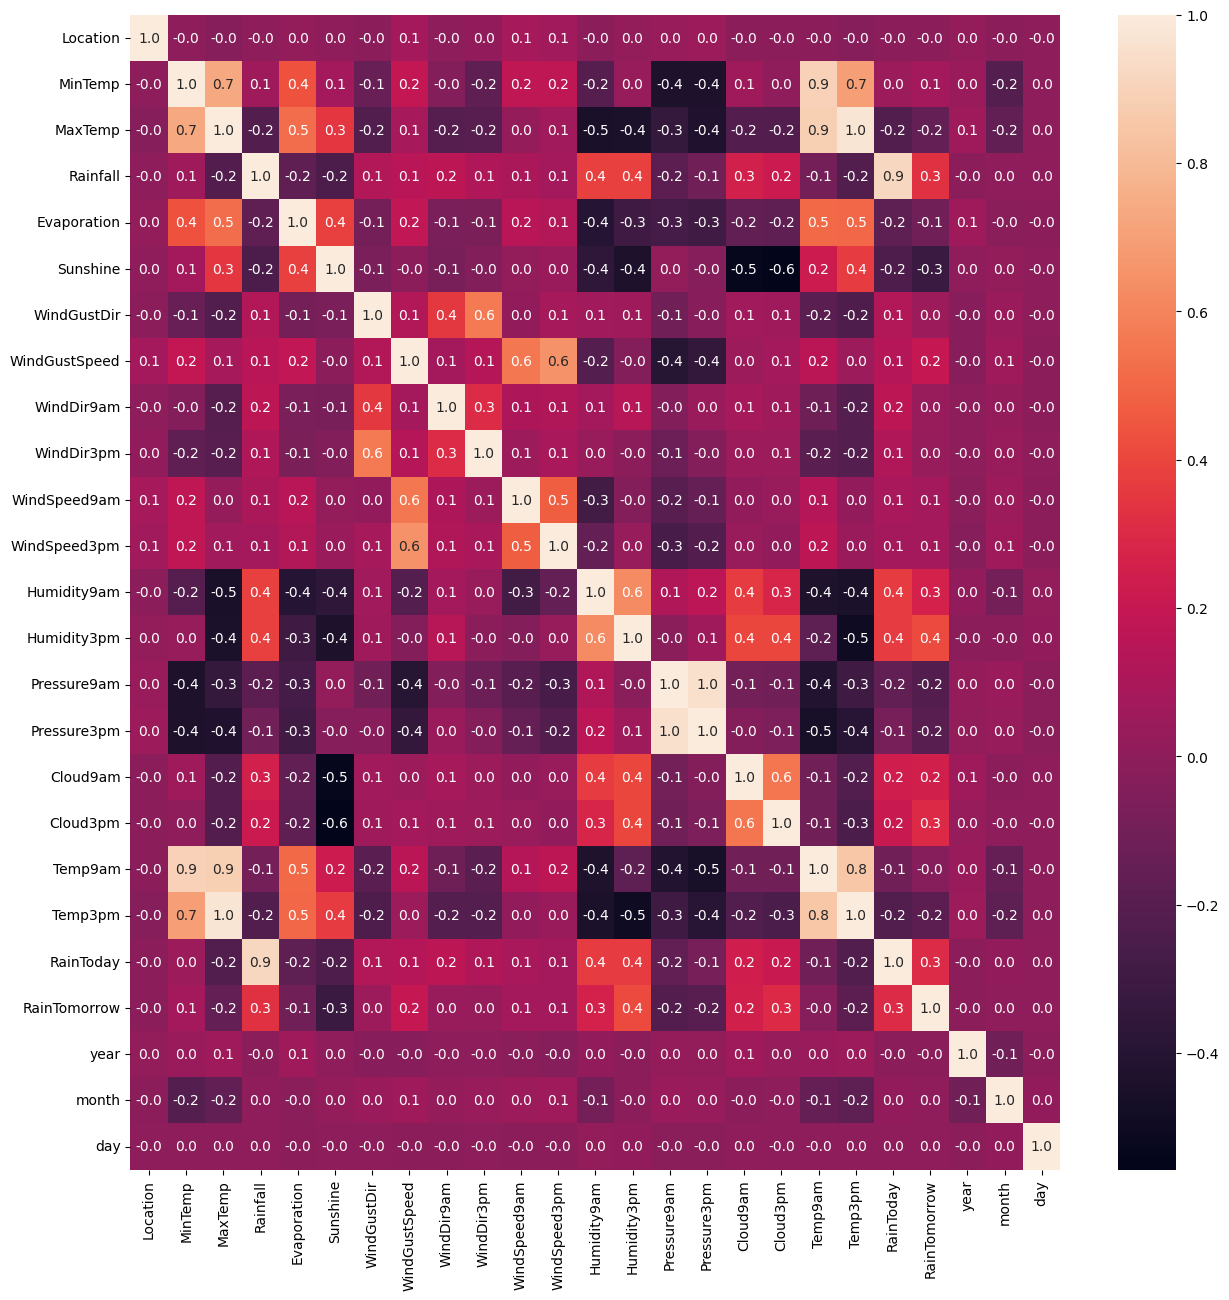

In [77]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True,fmt=".1f")

In [32]:
def standardize_columns(data: pd.DataFrame) -> pd.DataFrame:
    for column in data.columns:
        mean_val = data[column].mean()
        std_val = data[column].std()

        # Standardize the column
        data.loc[:, column] = (data[column] - mean_val) / std_val
    return data

In [33]:
# Standardize
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = standardize_columns(df[numeric_columns])

In [34]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,0.225574,-0.019239,-0.170339,-4.263897e-16,-1.108561e-15,W,0.498255,W,WNW,...,-1.500514,1.574230,0.000000,-0.000360,0.057516,No,No,2008,12,1
1,Albury,-0.878589,0.346790,-0.549873,-4.263897e-16,-1.108561e-15,WNW,0.498255,NNW,WSW,...,-1.371534,0.000000,0.000000,0.054736,0.493156,No,No,2008,12,2
2,Albury,0.133560,0.446616,-0.549873,-4.263897e-16,-1.108561e-15,WSW,0.699344,W,WSW,...,-1.205702,0.000000,-1.235802,0.752618,0.301474,No,No,2008,12,3
3,Albury,-0.547340,0.829283,-0.549873,-4.263897e-16,-1.108561e-15,NE,-1.512634,SE,E,...,-0.450245,0.000000,0.000000,0.220024,0.876520,No,No,2008,12,4
4,Albury,0.980086,1.538981,0.082683,-4.263897e-16,-1.108561e-15,W,0.196622,ENE,NW,...,-1.623161,1.129103,1.682826,0.164928,1.434139,No,No,2008,12,5


**Encode categorical data**

In [36]:
le = LabelEncoder()
le.fit(df['RainToday'])
df['RainToday'] = le.transform(df['RainToday'])


le.fit(df['RainTomorrow'])
df['RainTomorrow'] = le.transform(df['RainTomorrow'])


le.fit(df['WindGustDir'])
df['WindGustDir'] = le.transform(df['WindGustDir'])


le.fit(df['WindDir9am'])
df['WindDir9am'] = le.transform(df['WindDir9am'])


le.fit(df['WindDir3pm'])
df['WindDir3pm'] = le.transform(df['WindDir3pm'])


le.fit(df['Location'])
df['Location'] = le.transform(df['Location'])

In [37]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,2,0.225574,-0.019239,-0.170339,-4.263897e-16,-1.108561e-15,13,0.498255,13,14,...,-1.500514,1.574230,0.000000,-0.000360,0.057516,0,0,2008,12,1
1,2,-0.878589,0.346790,-0.549873,-4.263897e-16,-1.108561e-15,14,0.498255,6,15,...,-1.371534,0.000000,0.000000,0.054736,0.493156,0,0,2008,12,2
2,2,0.133560,0.446616,-0.549873,-4.263897e-16,-1.108561e-15,15,0.699344,13,15,...,-1.205702,0.000000,-1.235802,0.752618,0.301474,0,0,2008,12,3
3,2,-0.547340,0.829283,-0.549873,-4.263897e-16,-1.108561e-15,4,-1.512634,9,0,...,-0.450245,0.000000,0.000000,0.220024,0.876520,0,0,2008,12,4
4,2,0.980086,1.538981,0.082683,-4.263897e-16,-1.108561e-15,13,0.196622,1,7,...,-1.623161,1.129103,1.682826,0.164928,1.434139,0,0,2008,12,5


In [39]:
y = df['RainTomorrow']
X = df.drop('RainTomorrow', axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('x_train', X_train.shape)
print('x_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (116368, 24)
x_test (29092, 24)
y_train (116368,)
y_test (29092,)


In [62]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=350, learning_rate=0.2)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)


In [63]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_gbc)}')

Accuracy: 0.8563522617901829


In [64]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22726
           1       0.74      0.54      0.62      6366

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



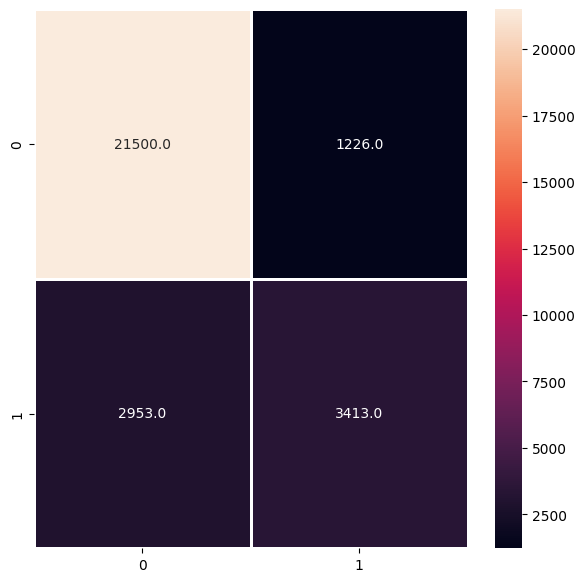

In [83]:
plt.figure(figsize=(7, 7))
cm = confusion_matrix(y_test, y_pred_gbc)
sns.heatmap(cm, annot=True, linewidth = 0.8, fmt = '.1f')
plt.show()
